## Task
Try to predict death rate from cirrhosis

In [46]:
import pandas as pd
import numpy as np

In [47]:
data = pd.read_csv('training-data.csv', delimiter=';', index_col='Index')
data.head(5)

,Urban,Latebirths,Wine,Liquor,CirrhosisDeath
Index,,,,,
1,44,33.2,5,30,41.2
2,43,33.8,4,41,31.7
3,48,40.6,3,38,39.4
4,52,39.2,7,48,57.5
5,71,45.5,11,53,74.8


In [48]:
X = data[['Urban','Latebirths','Wine','Liquor']]
y = data['CirrhosisDeath']

In [49]:
means, stds = X.mean(axis=0), X.std(axis=0)
X = (X - means) / stds

In [50]:
X = np.hstack((np.ones((X.shape[0], 1)), X))

In [51]:
def mserror(y, y_pred):
    "Mean square error of prediction"
    return sum((y-y_pred)**2)

In [52]:
def linear_prediction(X, w):
    return X.dot(w)

$$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} {((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)}$$
$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} {x_{kj}((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)},\ j \in \{1,2,3\}$$

In [53]:
def stochastic_gradient_step(X, y, w, train_ind, eta=0.01):
    grads = []
    grad0 = linear_prediction(X[train_ind], w) - y.tolist()[train_ind]
    grads.append(grad0)
    for i in range(1, len(X[train_ind])):
        grad_i = X[train_ind][i] * (linear_prediction(X[train_ind], w) - y.tolist()[train_ind])
        grads.append(grad_i)
    return  w - 2 * eta / len(X) * np.array(grads)

In [54]:
def stochastic_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
        
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        
        random_ind = np.random.randint(X.shape[0])
        
        step_w = stochastic_gradient_step(X, y, w, random_ind, eta)
        weight_dist = np.sqrt(np.sum((w-step_w)**2)) 
                                     
        w = step_w
        y_pred = linear_prediction(X, w)
        errors.append(mserror(y, y_pred))
        
        if verbose:
            print(w)
            
        iter_num += 1
        
    return w, errors

In [55]:
%%time
w_init = np.full(X.shape[1], 0)
stoch_grad_desc_weights, stoch_errors_by_iter = stochastic_gradient_descent(X, y, w_init, max_iter=1e5, verbose=False)
print(stoch_grad_desc_weights)

[ 66.06561432   0.07678844   9.32505161  13.30319824   0.97492139]
CPU times: user 35.8 s, sys: 49.9 ms, total: 35.9 s
Wall time: 35.9 s


Error by iter
Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

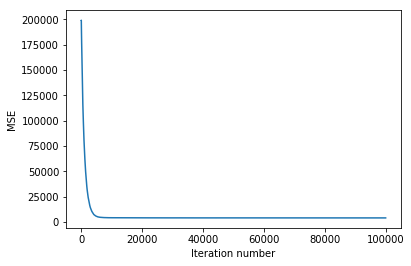

In [56]:
print ('Error by iter')
%pylab inline
plot(range(len(stoch_errors_by_iter)), stoch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

In [57]:
print ('Result error', stoch_errors_by_iter[-1])

Result error 3920.4903124892253


In [58]:
print ('Result weights')
stoch_grad_desc_weights

Result weights


array([ 66.06561432,   0.07678844,   9.32505161,  13.30319824,   0.97492139])

In [59]:
test_data = pd.read_csv('test-data.csv', delimiter=';', index_col='Index')
test_data

,Urban,Latebirths,Wine,Liquor,CirrhosisDeath
Index,,,,,
42,37,32.4,2,41,29.7
43,33,36.1,6,59,28.0
44,44,35.3,3,32,51.6
45,63,39.3,8,40,55.7
46,58,43.8,13,57,55.5


In [60]:
test_X = test_data[['Urban','Latebirths','Wine','Liquor']]
test_y = test_data[['CirrhosisDeath']]

In [61]:
# means, stds from training data
test_X = (test_X - means) / stds

In [62]:
test_X = np.hstack((np.ones((test_X.shape[0], 1)), test_X))

In [63]:
test_y_pred = test_X.dot(stoch_grad_desc_weights)

In [64]:
test_y = pd.DataFrame(test_y)
test_y['Predicted'] = test_y_pred
test_y

,CirrhosisDeath,Predicted
Index,,
42,29.7,33.178985
43,28.0,46.400789
44,51.6,38.509691
45,55.7,53.721287
46,55.5,69.850789


## Conclusion
In this case linear regression has shown not so good results sometimes. I suppose because of small sample of data.